In [53]:
%load_ext autoreload
%autoreload 2
import random
import numpy as np
import matplotlib.pyplot as plt
from utils import plot_NQueens, plot_evolution

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Local Search: Genetic Algorithm

## 1.Genrating Phrases

In this section we consider a toy problem: generating a target phrases (e.g. "genetic algorithm") from an initial polupation of random strings. Assume the length of the target is known.

Problem Formulation: 

1. Direct Representation: just strings.
2. Exponential Search Space: $m^l$ where $m$ is the size of the alphabet (set of characters in our interest) and $l$ is the length of the string.

Now that we want to solve it with GA:
1. Chromesome: directly use the string itself.
2. Fitness: how match/close an individual is to the target.
3. Mating: combine two strings in someway to generate a new one.

The following cells will walk you through this problem to show the basic idea of GA

In [59]:
# setting up the problem
target = 'Genetic Algorithm'
u_case = [chr(x) for x in range(65, 91)]
l_case = [chr(x) for x in range(97, 123)]
gene_pool = u_case + l_case + [' '] # all English chracters and white space

def init_population(pop_size, gene_pool, state_length):
    """
    Randomly initialize a population for genetic algorithm
        pop_size  :  Number of individuals in population
        gene_pool   :  List of possible values for individuals
        state_length:  The length of each individual
    """

    population = []
    for _ in range(pop_size):
        new_individual = "".join(random.choices(gene_pool, k=state_length))
        population.append(new_individual)

    return population

# test
init_pop = init_population(10, gene_pool, len(target))
init_pop

['NywZfCPLTUeyODIhm',
 'oKrdYuVXrLtAiPzEI',
 'sTRfdxArhPeMUNvLj',
 'nPNKAYLrKieRJqZkM',
 'sYgZdHMMGCZTecPdP',
 'oIdeZWCxQOI cGPDN',
 'JKuafQYLWNUWe ES ',
 'UrjvwbCWomFmKDBha',
 'zNoCDZAmdaxuUcmvg',
 'kxXwKYEojWtwTzx M']

In [60]:
def fitness_fn(sample):
    cnt = 0
    for i in range(len(target)):
        if sample[i] == target[i]:
            cnt += 1
    return cnt/len(target)
# test
fitness_fn(init_pop[0])

0.11764705882352941

In [61]:
def select(r, population, fitness_fn):
    selection = []
    sorted_pop = sorted(population, key= lambda p:fitness_fn(p), reverse= True)
    for i in range(r):
        selection.append(sorted_pop[i])
    return selection
# test
parents = select(2, init_pop, fitness_fn)
parents

['NywZfCPLTUeyODIhm', 'oIdeZWCxQOI cGPDN']

In [49]:
def recombine(x, y):
    n = len(x)
    pos = random.randint(0,n-1)
    child = x[0:pos+1] + y[pos+1: n]
    return child

def mutate(x, gene_pool, pmut):
    """
    apply mutation to *x* by randomly replacing one of its gene from *gene_pool*
    """
    if random.uniform(0, 1) >= pmut:
        return x

    n = len(x)
    g = len(gene_pool)
    c = random.randrange(0, n)
    r = random.randrange(0, g)

    new_gene = gene_pool[r]
    return x[:c] + new_gene + x[c + 1:]

# test
child = mutate(recombine(*parents), gene_pool, 0.1)
child

'VjBfyuQ znbJypjXp'

In [62]:
# now refactor things into a *Problem* abstraction
# you can directly reuse what you have implemented above
from abc import ABC, abstractmethod

class GAProblem(ABC):
    @abstractmethod
    def init_population(self, pop_size): pass

    @abstractmethod
    def fitness(self, sample): pass

    @abstractmethod
    def reproduce(self, population): pass

    @abstractmethod
    def replacement(self, old, new): pass

class PhraseGeneration(GAProblem):
    def __init__(self, target, alphabet):
        self.target = target
        self.alphabet = alphabet

    def init_population(self, pop_size):
        # raise NotImplementedError()
        return init_population(pop_size, self.alphabet, len(self.target))

    def fitness(self, sample):
            cnt = 0
            for i in range(len(self.target)):
                if sample[i] == self.target[i]:
                    cnt += 1
            return cnt/len(target)
    
    def select(r, population, fitness_fn):
        selection = []
        sorted_pop = sorted(population, key= lambda p:fitness_fn(p), reverse= True)
        for i in range(r):
            selection.append(sorted_pop[i])
        return selection
    
    def reproduce(self, population, mutation_rate):

        def recombine(x, y):
           n = len(x)
           pos = random.randint(0,n-1)
           child = x[0:pos+1] + y[pos+1: n]
           return child

        def mutate(x, gene_pool, pmut):
            if random.uniform(0, 1) >= pmut:
                 return x
            n = len(x)
            g = len(gene_pool)
            c = random.randrange(0, n)
            r = random.randrange(0, g)
            new_gene = gene_pool[r]
            return x[:c] + new_gene + x[c + 1:]
        
        # parents = self.select(2, population, fitness_fn)
        new_pop = []
        for i in range(len(population)):
            for j in range(i+1, len(population)):
                new_pop.append(mutate(recombine(population[i], population[j]), self.alphabet, mutation_rate))
        return new_pop
        # return mutate(recombine(*parents), self.alphabet, mutation_rate)
    
    def replacement(self, old, new):
        # field = list(range(len(old)))
        # worst_gen = min(field, key=lambda i:fitness_fn(old[i]))
        # new = old[0:worst_gen] + [new] + old[worst_gen+1: len(old)]
        
        field = old + new
        new = select(len(old), field, fitness_fn)
        return new

def genetic_algorithm(
        problem: GAProblem, 
        ngen, n_init_size, mutation_rate, 
        log_intervel=100
    ):

    population = problem.init_population(n_init_size)
    best = max(population, key=problem.fitness)
    history = [(0, list(map(problem.fitness, population)))]

    for gen in range(ngen):
        next_gen    = problem.reproduce(population, mutation_rate)
        population  = problem.replacement(population, next_gen)

        if gen % log_intervel == 0:
            current_best = max(population, key=problem.fitness)
            if problem.fitness(current_best) > problem.fitness(best): best = current_best
            print(f"Generation: {gen}/{ngen},\tBest: {best},\tFitness={problem.fitness(best)}")         
            history.append((gen, list(map(problem.fitness, population))))
    
    history.append((ngen-1, list(map(problem.fitness, population))))
    return best, history

In [63]:
# now set up the parameters
ngen = 1200
max_population = 120
mutation_rate = 0.08

sid = 12110714 #TODO:  replace this with your own sid
target = f"Genetic Algorithm by {sid}" 
u_case = [chr(x) for x in range(65, 91)]
l_case = [chr(x) for x in range(97, 123)]
number = [chr(x) for x in range(48, 58)]
alphabet = u_case + l_case + number + [' '] # TODO: fix this: what is the search space now?
problem = PhraseGeneration(target, alphabet)

# and run it
solution, history = genetic_algorithm(problem, ngen, max_population, mutation_rate)
solution

Generation: 0/1200,	Best: tfE15iO50R8DgiuUeS3gfMr1eD7Pq,	Fitness=0.13793103448275862
Generation: 100/1200,	Best: Genetic Algorithm by 12110714,	Fitness=1.0
Generation: 200/1200,	Best: Genetic Algorithm by 12110714,	Fitness=1.0
Generation: 300/1200,	Best: Genetic Algorithm by 12110714,	Fitness=1.0
Generation: 400/1200,	Best: Genetic Algorithm by 12110714,	Fitness=1.0
Generation: 500/1200,	Best: Genetic Algorithm by 12110714,	Fitness=1.0
Generation: 600/1200,	Best: Genetic Algorithm by 12110714,	Fitness=1.0
Generation: 700/1200,	Best: Genetic Algorithm by 12110714,	Fitness=1.0
Generation: 800/1200,	Best: Genetic Algorithm by 12110714,	Fitness=1.0
Generation: 900/1200,	Best: Genetic Algorithm by 12110714,	Fitness=1.0
Generation: 1000/1200,	Best: Genetic Algorithm by 12110714,	Fitness=1.0
Generation: 1100/1200,	Best: Genetic Algorithm by 12110714,	Fitness=1.0


'Genetic Algorithm by 12110714'

In [ ]:
# visualize the evolution of the polulation
bins = np.linspace(0, max_population,max_population+1)
plot_evolution(history, bins)
bins

## 2. N-Queens Problem

It is possible to solve the N-Queens problem with slight modifications.

For the problem:

1. Direct Representation: placement of queens.
2. Search Space: $n^n$, if we don't use any constraints.

To use GA:

Actually a new fitness function is the minimum modification you need for this problem.

Others are alomost the same as the previous problem.

In [39]:
class NQueensProblem(GAProblem):

    def __init__(self, n):
        self.n = n
        self.max_fitness =  n*(n-1)//2 # max number if non-attacking pairs

    def init_population(self, pop_size):
        population = []
        for _ in range(pop_size):
            new_individual = "".join(random.choices(gene_pool, k=self.n))
            population.append(new_individual)
        return population
    
    def fitness(self, queens):
        cnt = self.max_fitness
        for i in range(self.n):
            for j in range(i+1, self.n):
                if queens[i] == queens[j] or abs(i-j) == abs(int(queens[i]) - int(queens[j])):
                    cnt -= 1
        return cnt / self.max_fitness

    def reproduce(self, population, mutation_rate):

        def recombine(x, y):
           n = len(x)
           pos = random.randint(0,n-1)
           child = x[0:pos+1] + y[pos+1: n]
           return child

        def mutate(x, gene_pool, pmut):
            if random.uniform(0, 1) >= pmut:
                 return x
            n = len(x)
            g = len(gene_pool)
            c = random.randrange(0, n)
            r = random.randrange(0, g)
            new_gene = gene_pool[r]
            return x[:c] + new_gene + x[c + 1:]
        
        new_pop = []
        for i in range(len(population)):
            for j in range(i+1, len(population)):
                new_pop.append(mutate(recombine(population[i], population[j]), gene_pool, mutation_rate))
        return new_pop

    def replacement(self, old, new):
       
        def select(r, population, fitness_fn):
            selection = []
            sorted_pop = sorted(population, key= lambda p:self.fitness(p), reverse= True)
            for i in range(r):
                 selection.append(sorted_pop[i])
            return selection
        
        field = old + new
        new = select(len(old), field, self.fitness) 
        return new

    def __repr__(self):
        return f"{self.n}-Queens Problem"

In [64]:
from utils import plot_NQueens
ngen = 1000
init_size = 120
mutation_rate = 0.08
n = 8
gene_pool = [chr(x) for x in range(48, 48+n)]
problem = NQueensProblem(n)
solution, history = genetic_algorithm(problem, ngen, init_size, mutation_rate)

Generation: 0/1000,	Best: 26175364,	Fitness=0.9642857142857143
Generation: 100/1000,	Best: 36271405,	Fitness=1.0
Generation: 200/1000,	Best: 36271405,	Fitness=1.0
Generation: 300/1000,	Best: 36271405,	Fitness=1.0
Generation: 400/1000,	Best: 36271405,	Fitness=1.0
Generation: 500/1000,	Best: 36271405,	Fitness=1.0
Generation: 600/1000,	Best: 36271405,	Fitness=1.0
Generation: 700/1000,	Best: 36271405,	Fitness=1.0
Generation: 800/1000,	Best: 36271405,	Fitness=1.0
Generation: 900/1000,	Best: 36271405,	Fitness=1.0


f:\Artificial Intelligence\Lab\Practice7\utils.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


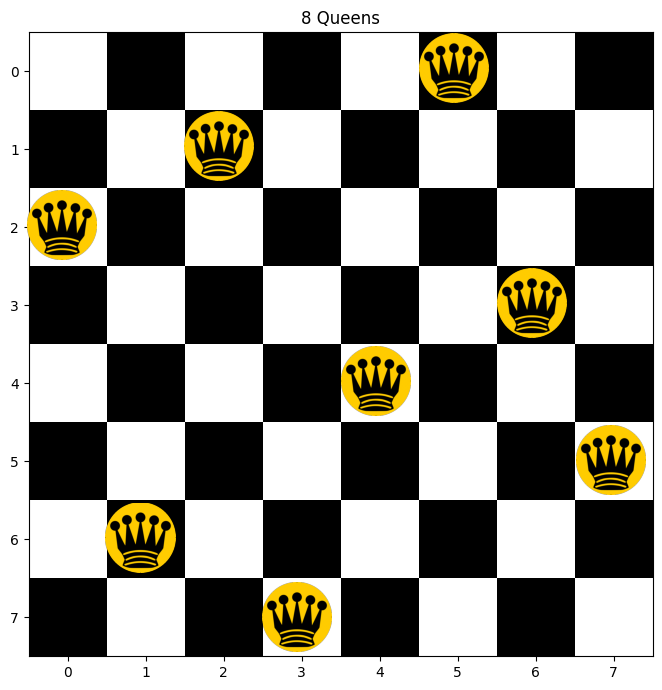

In [52]:
# Example of how to use this function
# plot_NQueens([4, 2, 0, 6, 1, 7, 5, 3])
# replace the parameter with your own results
plot_NQueens(list(map(lambda x:int(x), solution)))

In [ ]:
# Visualize the evolution of the polulation
bins = np.linspace(0, problem.max_fitness, problem.max_fitness)
plot_evolution(history, bins)